In [2]:
from UniModalReps import *
import torchvision.models as  models
import torch

In [3]:
resnet_50 = models.resnet50(pretrained=True)
res50_C4 = Resnet_C4(resnet_50)
    
# Setting variables for data loading
data_root = '/home/jingwen/data/refcoco'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco+'
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)

loading dataset refcoco+ into memory...
creating index...
index created.
DONE (t=8.03s)


In [4]:
load_statistics(refer)
splits = make_split(dataset)
    
ref_ids_dict = get_refs_id_dict(refer,splits)
refs_dict = get_refslist(refer,ref_ids_dict)

from collections import defaultdict
cat_cnts = defaultdict(int)
for ref in refs_dict['train']:
    cat_cnts[ref['category_id']] += 1
cat_cnts = [(key, value) for key, value in cat_cnts.items()]
cat_cnts = sorted(cat_cnts, key=lambda x: x[1], reverse=True)
cat_cnts = cat_cnts[:10]
print(cat_cnts)
vis_cats = [item[0] for item in cat_cnts]

141564 expressions for 49856 refs in 19992 images.
[(1, 20998), (24, 918), (22, 908), (25, 858), (62, 854), (51, 837), (59, 700), (19, 671), (54, 647), (21, 644)]


In [5]:
vis_by_cat = defaultdict(list)
vis_id_by_cat = defaultdict(list)
vis_cnts = defaultdict(int)
max_vis_num = 100
for ref, ref_id in zip(refs_dict['train'], ref_ids_dict['train']):
    if ref['category_id'] in vis_cats and vis_cnts[ref['category_id']] < max_vis_num:
        vis_by_cat[ref['category_id']].append(ref)
        vis_id_by_cat[ref['category_id']].append(ref_id)
        vis_cnts[ref['category_id']] += 1

In [76]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

res50_C4 = res50_C4.cuda()
for cat in vis_by_cat:
    img_list = load_images(refer,vis_by_cat[cat])
    bounded_image_list = get_bounded_image(refer,vis_id_by_cat[cat],img_list)
    bounded_image_list = [transform(Image.fromarray(img)).cuda() for img in bounded_image_list]
    bounded_outputs = []
    with torch.no_grad():
        for cropped_tensor in bounded_image_list:
            # Not RGB image
            if cropped_tensor.shape[0] != 3:
                continue
            cropped_tensor = cropped_tensor.unsqueeze(0)
            cropped_tensor = cropped_tensor.float()
            bounded_outputs.append(res50_C4(cropped_tensor).cpu().numpy())
    outputs = [np.mean(np.mean(np.mean(output, axis=3), axis=2), axis=0) for output in bounded_outputs]
    outputs = np.stack(outputs)
    print(outputs.shape)
    np.save('feat/%s' % cat, outputs)
    

(100, 2048)
(100, 2048)
(100, 2048)
(97, 2048)
(100, 2048)
(100, 2048)
(100, 2048)
(100, 2048)
(100, 2048)
(100, 2048)


In [17]:
from pycocotools.coco import COCO
dataType = 'train2014'
dataDir = '/home/jingwen/data/mscoco'
annFile = '{}/annotations/instances_{}.json'.format(dataDir, dataType)
coco = COCO(annFile)

loading annotations into memory...
Done (t=11.79s)
creating index...
index created!


In [19]:
cats = coco.loadCats(coco.getCatIds())
id2cat = {item['id']: item['name'] for item in cats}

In [77]:
import os
feats = []
labels = []
id2cat_new = {}
for i, name in enumerate(os.listdir('feat')):
    filename = os.path.join('feat', name)
    cid = int(os.path.splitext(name)[0])
    cat = id2cat[cid]
    id2cat_new[i] = cat
    data = np.load(filename)
    print(cat, data.shape)
    
    feats.append(data)
    labels.extend([i] * data.shape[0])
feats = np.vstack(feats)
labels = np.array(labels)

(u'horse', (97, 2048))
(u'bowl', (100, 2048))
(u'elephant', (100, 2048))
(u'cow', (100, 2048))
(u'pizza', (100, 2048))
(u'sandwich', (100, 2048))
(u'chair', (100, 2048))
(u'zebra', (100, 2048))
(u'person', (100, 2048))
(u'giraffe', (100, 2048))


In [78]:
from sklearn.manifold import TSNE
RS = 20190930
tsne = TSNE(random_state = RS).fit_transform(feats)

In [79]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})

In [135]:
import matplotlib.patheffects as PathEffects
def scatter(x, colors, colors2id):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        if colors2id[i] in colors2id.values():
#         if colors2id[i] in ['giraffe', 'horse', 'zebra', 'person', 'elephant', 'cow']:
            idx = (colors == i)
            sc = ax.scatter(x[idx,0], x[idx,1], lw=0, s=40,
                            c=palette[i], label=colors2id[i])
    ax.set_xlim((-15, 15))
    ax.set_ylim((-15, 15))
    ax.axis('off')
#     ax.axis('tight')
    lgd = ax.legend(bbox_to_anchor=(1.5,0.5), loc = 'right')
    f.savefig('tsne.png', bbox_extra_artists=(lgd, ax), bbox_inches='tight')

    return f, ax, sc#, txts

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.collections.PathCollection at 0x7f785a373550>)

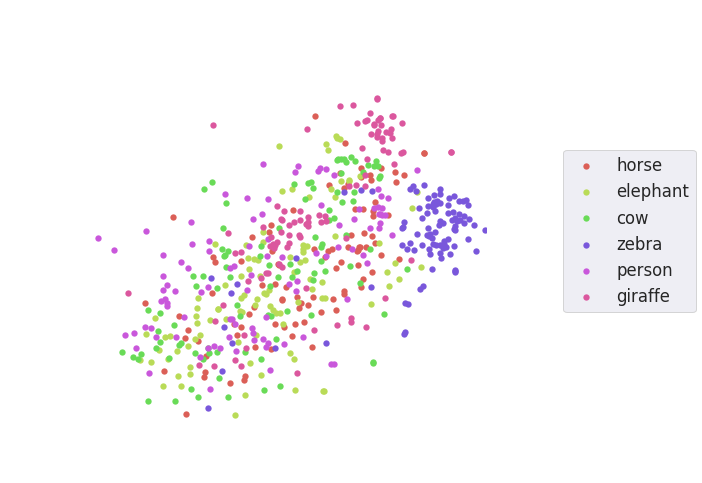

In [136]:
scatter(tsne, labels, id2cat_new)